# Data Reading

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
#matplotlib.style.use('ggplot')

In [6]:
users = pd.read_csv('../data/ml-100k/u.user', sep='|', names=['user_id', 'age', 'sex', 'occupation', 'zip_code'])
ratings = pd.read_csv('../data/ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'unix_timestamp'])
movies = pd.read_csv('../data/ml-100k/u.item', sep='|', names=['movie_id','title','release date','video release date','IMDb URL','unknown','Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'],encoding='latin-1')
movielens = pd.merge(pd.merge(movies, ratings), users)
moviesRated = pd.merge(movies, ratings)
usersRatings = pd.merge(users, ratings)

# Movie Genre Analysis

## I. How do the movies vary with respect to genres?

In [7]:
genres = ['unknown','Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

### A. Count how many movies are in each genre

In [8]:
genres_count = []
for g in genres:
    genres_count.append(movies[g].sum())

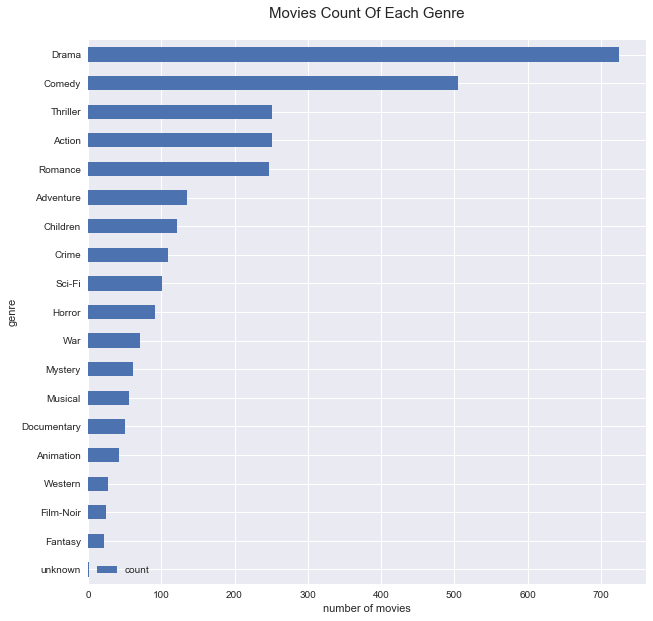

In [9]:
df_genres_count = pd.DataFrame()
df_genres_count['genre'] = genres
df_genres_count['count'] = genres_count
df_genres_count = df_genres_count.sort_values(by='count')
ax = df_genres_count.plot(kind='barh',x='genre',y='count',figsize=[10,10])
ax.set_title('Movies Count Of Each Genre\n',fontsize=15)
ax.set_xlabel('number of movies')
plt.savefig('../pics/0401MoviesCountOfEachGenre.png', dpi=100)

### As we can see from the graph above, counts of movies of each genre vary greatly. 
#### The genre 'drama' has the most movies while 'fantasy' the least. 
#### According the count of movies, the 3 most popular genres are 'drama', 'comedy', ' thriller', and the 3 least popular genres are 'fantasy', 'film noir', 'western'.
#### P.S. Movies in the data may have multiple genres.

### B. Count the avg. rating of movies in each genre

In [10]:
genres_rating = []
for g in genres:
    rating = moviesRated[moviesRated[g]==1]['rating']
    rating_mean = rating.sum()/rating.count()
    genres_rating.append(rating_mean)

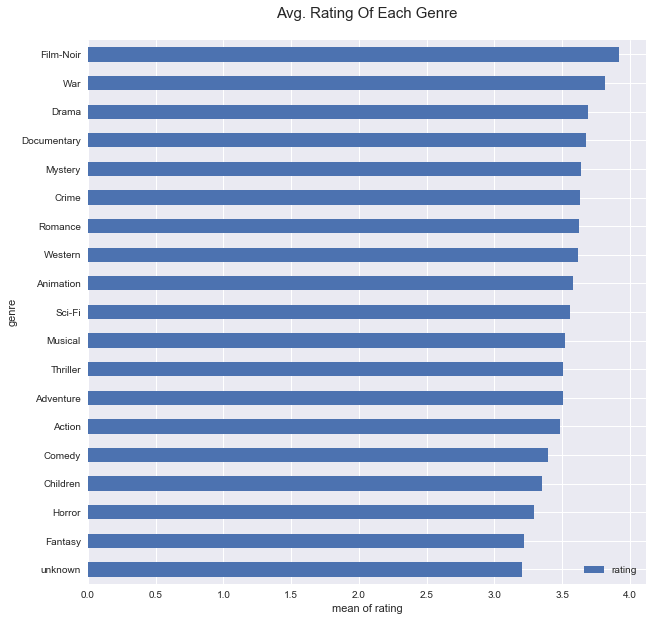

In [11]:
df_genres_rating = pd.DataFrame()
df_genres_rating['genre'] = genres
df_genres_rating['rating'] = genres_rating
df_genres_rating = df_genres_rating.sort_values(by='rating')
ax = df_genres_rating.plot(kind='barh',x='genre',y='rating',figsize=[10,10])
ax.set_title('Avg. Rating Of Each Genre\n',fontsize=15)
ax.set_xlabel('mean of rating')
plt.savefig('../pics/0402AvgRatingOfEachGenre.png', dpi=100)

In [12]:
df_genres = pd.merge(df_genres_count,df_genres_rating)
df_genres = df_genres[df_genres['count']>100].sort_values(by='rating')# Only consider genres of which movies have at least 50 ratings. 
genres_bigSample = df_genres[df_genres['count']>100]['genre'].values
genres_bigSample

array(['Children', 'Comedy', 'Action', 'Adventure', 'Thriller', 'Sci-Fi',
       'Romance', 'Crime', 'Drama'], dtype=object)

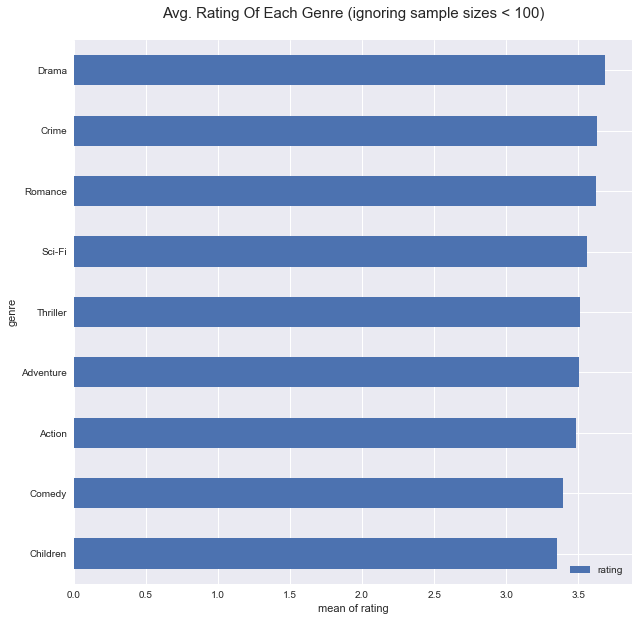

In [13]:
ax = df_genres.plot(kind='barh',x='genre',y='rating',figsize=[10,10])
ax.set_title('Avg. Rating Of Each Genre (ignoring sample sizes < 100)\n',fontsize=15)
ax.set_xlabel('mean of rating')
plt.savefig('../pics/0403AvgRatingOfEachGenre(IgnoringSmallSampleSizes).png', dpi=100)

#### In order to be convincible,  we only consider genres of which movies have at least 100 ratings. 
#### As we can see from the graph above, 'drama' has the highest average rating, while 'children' the lowest. Yet, generally speaking, ratings don't differ much among different genres.

## II. How does the gender affect the rating of movies in each genre?

In [10]:
genres_rating_M = []
genres_rating_F = []
genres_rating_bigSample = []
for g in genres_bigSample:
    rating_M = movielens[(movielens[g]==1)&(movielens['sex']=='M')]['rating']
    rating_mean_M = rating_M.sum()/rating_M.count()
    genres_rating_M.append(rating_mean_M)
    rating_F = movielens[(movielens[g]==1)&(movielens['sex']=='F')]['rating']
    rating_mean_F = rating_F.sum()/rating_F.count()
    genres_rating_F.append(rating_mean_F)
    rating = movielens[movielens[g]==1]['rating']
    rating_mean = rating.sum()/rating.count()
    genres_rating_bigSample.append(rating_mean)

In [11]:
df_genres_genderRating = pd.DataFrame()
df_genres_genderRating['genre'] = genres_bigSample
df_genres_genderRating['rating_M'] = genres_rating_M
df_genres_genderRating['rating_F'] = genres_rating_F
df_genres_genderRating['rating'] = genres_rating_bigSample
df_genres_genderRating = df_genres_genderRating.sort_values(by='rating')
df_genres_genderRating['genre'].values

array(['Children', 'Comedy', 'Action', 'Adventure', 'Thriller', 'Sci-Fi',
       'Romance', 'Crime', 'Drama'], dtype=object)

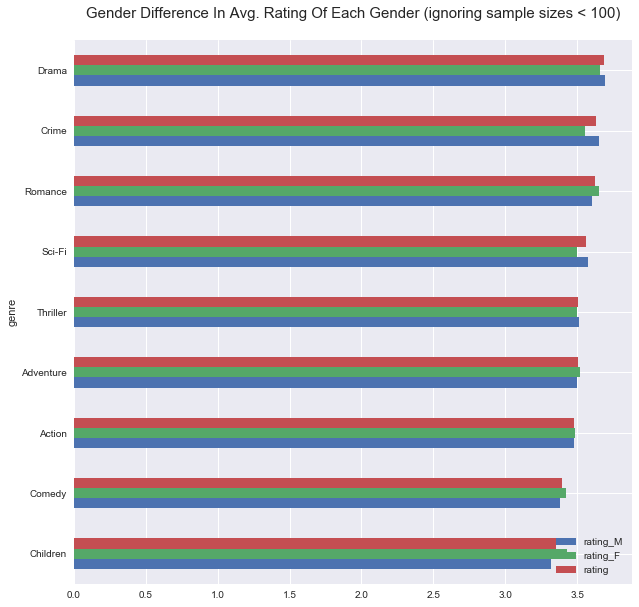

In [12]:
ax = df_genres_genderRating.plot(kind='barh',figsize=[10,10],x='genre')
ax.set_title('Gender Difference In Avg. Rating Of Each Gender (ignoring sample sizes < 100)\n',fontsize=15)
plt.savefig('../pics/0404GenderDifferenceInAvgRatingOfEachGender.png', dpi=100)

#### The graph above shows avg. rating of female, male and both with respect to different genres.  We still only consider genres of which movies have at least 100 ratings to exclude very small samples.
#### As we can see, the difference between male and female in rating is not very big. But we may still reckon that women tend to love some genres better such as 'romance' and 'children's', while men 'crime' and 'sci-fi'.

## III. Does the profession matter to movie genre preference?

In [13]:
occupations = users['occupation'].values
occupations = list(set(occupations))[2:] # delete 'none' and 'other' from the occupation list

In [14]:
df_genre_occ = pd.DataFrame(index=genres_bigSample)
for occ in occupations:
    genres_rating = []
    for g in genres_bigSample:
        rating = movielens[(movielens[g]==1)&(movielens['occupation']==occ)]['rating']
        if rating.count():
            rating_mean = rating.sum()/rating.count()
        else:
            rating_mean = 0 #Fill missing data point with 0
        genres_rating.append(rating_mean)
    df_genre_occ[occ] = genres_rating

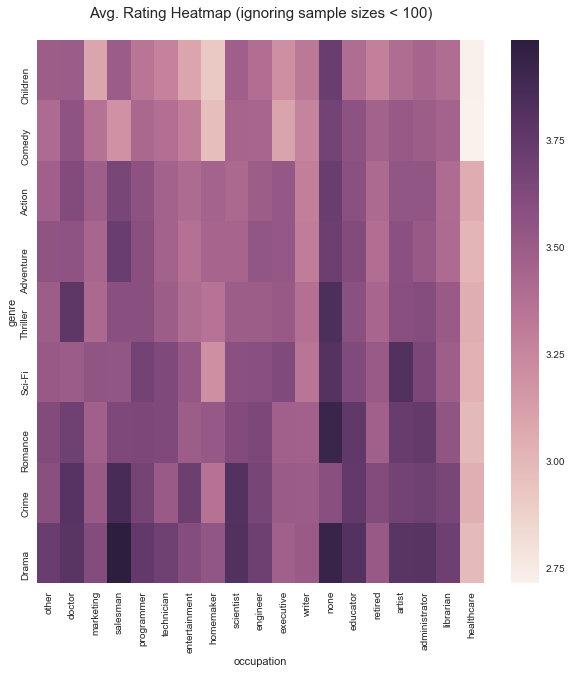

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax = sns.heatmap(df_genre_occ)
for item in ax.get_xticklabels():
    item.set_rotation(90)
ax.set_title('Avg. Rating Heatmap (ignoring sample sizes < 100)\n',fontsize=15)
ax.set_xlabel('occupation')
ax.set_ylabel('genre')
plt.savefig('../pics/0405AvgRatingHeatmap.png', dpi=100)
plt.show()

#### The heatmap above shows the different ratings of movies of different genres with respect to users' occupations.
#### Users of some occupations tend to rate higher such as 'lawyer', 'artist', 'salesman' and 'administrator', while some lower such as 'healthcare', 'homemaker', 'writer' and 'retired'.
#### Some genres tend to be prefered by certain occupations. E.g., 'adventure' and 'thriller' movies are more welcome among lawyers, 'sci-fi' are liked better by artists.
#### Likewise, certain occupations have certain preference. E.g., besides the commonly popular genres, salespeople also like 'adventure',  doctors 'thriller',  executives 'sci-fi'.